In [1]:
path_notebook = '/content/drive/MyDrive/Desafio_Kaggle/'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
import os
import sys
sys.path.insert(0, os.path.dirname(path_notebook))

In [4]:
import AleTransforms as trf
import AleDatasetAnalysis as dat
import AleMLAnalysis as aml
import AleExplainers as exp
import AleLearners as lrn

In [5]:
import importlib
importlib.reload(trf)
importlib.reload(dat)
importlib.reload(aml)
importlib.reload(exp)
importlib.reload(lrn)

<module 'AleLearners' from '/content/drive/MyDrive/Desafio_Kaggle/AleLearners.py'>

In [6]:
import tensorflow as tf
from IPython.display import Image
from IPython.display import clear_output

import pandas as pd
import numpy as np
import random
import math

from joblib import Parallel, delayed
from multiprocessing import cpu_count

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

import itertools

import gc

# Dataset

In [7]:
#https://www.analyticsvidhya.com/blog/2021/07/implementing-lstm-for-human-activity-recognition-using-smartphone-accelerometer-data/
#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#https://amitness.com/2020/04/recurrent-layers-keras/

In [8]:
!wget -c https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz -O - | tar -xz

--2021-10-11 15:02:03--  https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Resolving www.cis.fordham.edu (www.cis.fordham.edu)... 150.108.68.29
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404612 (11M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]  10.88M  10.8MB/s    in 1.0s    

2021-10-11 15:02:05 (10.8 MB/s) - written to stdout [11404612/11404612]



In [9]:
colunas = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = colunas)
df['z-axis'] = df['z-axis'].str.replace(';', '').astype(float)
df['timestamp'] = df['timestamp'].mask(df['timestamp'] == 0, np.nan)
df = df.dropna()
df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,1.316233e+14,9.000000,-1.570000,1.690000
1098200,19,Sitting,1.316234e+14,9.040000,-1.460000,1.730000
1098201,19,Sitting,1.316234e+14,9.080000,-1.380000,1.690000
1098202,19,Sitting,1.316235e+14,9.000000,-1.460000,1.730000


# Encoder do Alvo

In [10]:
alvo = 'activity'
alvos = list(df[alvo].unique())
for classe in alvos:
    df[classe] = (df[alvo] == classe).astype(int)
df = df.drop(alvo, axis = 1)
df

,user,timestamp,x-axis,y-axis,z-axis,Jogging,Walking,Upstairs,Downstairs,Sitting,Standing
0,33,4.910596e+13,-0.694638,12.680544,0.503953,1,0,0,0,0,0
1,33,4.910606e+13,5.012288,11.264028,0.953424,1,0,0,0,0,0
2,33,4.910611e+13,4.903325,10.882658,-0.081722,1,0,0,0,0,0
3,33,4.910622e+13,-0.612916,18.496431,3.023717,1,0,0,0,0,0
4,33,4.910633e+13,-1.184970,12.108489,7.205164,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1098199,19,1.316233e+14,9.000000,-1.570000,1.690000,0,0,0,0,1,0
1098200,19,1.316234e+14,9.040000,-1.460000,1.730000,0,0,0,0,1,0
1098201,19,1.316234e+14,9.080000,-1.380000,1.690000,0,0,0,0,1,0
1098202,19,1.316235e+14,9.000000,-1.460000,1.730000,0,0,0,0,1,0


# Separação Treino/Teste

In [11]:
colunas_id = ['user']
coluna_temporal = 'timestamp'

In [12]:
frac_treino_ids = 0.8

set_ids = set(df.loc[:, colunas_id].itertuples(index = False, name = None))
random.seed(42)
set_ids_treino = set(random.sample(set_ids, round(len(set_ids)*frac_treino_ids)))

frac_treino_tempo = 0.8

num_div = max(round(1/frac_treino_tempo), round(1/(1-frac_treino_tempo)))
corta_valores_tempo = trf.CortaIntervalosQuasiUniforme(df.loc[:, coluna_temporal].values, num_div = num_div)
min_max = corta_valores_tempo.pares_minimo_maximo_discretizacao()
interv_tempo_treino = (min_max[0][0], min_max[num_div-1][0])

In [13]:
print(set_ids_treino)
print(interv_tempo_treino)

#Aqui teria que guardar esses dados para poder identificar o que é teste em outros datasets futuros

{(21,), (32,), (23,), (34,), (9,), (36,), (11,), (13,), (1,), (28,), (3,), (5,), (16,), (7,), (18,), (20,), (33,), (8,), (35,), (10,), (12,), (14,), (25,), (27,), (2,), (4,), (31,), (6,), (19,)}
(73452342000.0, 59401642330000.0)


In [14]:
def cria_masks(df, colunas_id, coluna_temporal, set_ids_treino, interv_tempo_treino):
    flag_id_treino = pd.Series(df.loc[:, colunas_id].itertuples(index = False, name = None)).isin(set_ids_treino).values
    flag_tempo_treino = ((df.loc[:, coluna_temporal] >=  interv_tempo_treino[0]) & (df.loc[:, coluna_temporal] <  interv_tempo_treino[1])).values
    mask_treino = (flag_id_treino & flag_tempo_treino)
    mask_teste_amostra = ((~flag_id_treino) & flag_tempo_treino)
    mask_teste_tempo = (flag_id_treino & (~flag_tempo_treino))
    mask_teste = ((~flag_id_treino) & (~flag_tempo_treino))
    return mask_treino, mask_teste_amostra, mask_teste_tempo, mask_teste

In [15]:
mask_treino, mask_teste_amostra, mask_teste_tempo, mask_teste = cria_masks(df, colunas_id, coluna_temporal, set_ids_treino, interv_tempo_treino)

# Preparação da Base

In [16]:
features = ['x-axis', 'y-axis', 'z-axis']
#Aqui precisa salvar a lista de features para aplicar em outro dataset futuro

In [17]:
medias = df.loc[mask_treino, features].mean(axis = 0)
desvios = df.loc[mask_treino, features].std(axis = 0)
#Aqui precisa salvar as medias e desvios para pode recuperar e aplicar em outro dataset futuro

fil_desv = desvios > 0

medias_y = df.loc[mask_treino, alvos].mean(axis = 0)

In [18]:
df['tempo_norm'] = (df[coluna_temporal] - interv_tempo_treino[0])/(interv_tempo_treino[1] - interv_tempo_treino[0])
df.loc[:, np.array(features)[fil_desv]] = (df.loc[:, np.array(features)[fil_desv]] - medias[fil_desv])/desvios[fil_desv]

features_ext = list(np.append(np.array(features)[fil_desv], ['tempo_norm']))
#Valoes levar o tempo normalizado como uma feature a mais

df

,user,timestamp,x-axis,y-axis,z-axis,Jogging,Walking,Upstairs,Downstairs,Sitting,Standing,tempo_norm
0,33,4.910596e+13,-0.175383,0.745223,-0.043668,1,0,0,0,0,0,0.826462
1,33,4.910606e+13,0.718189,0.527043,0.049284,1,0,0,0,0,0,0.826464
2,33,4.910611e+13,0.701128,0.468302,-0.164787,1,0,0,0,0,0,0.826465
3,33,4.910622e+13,-0.162587,1.641019,0.477425,1,0,0,0,0,0,0.826467
4,33,4.910633e+13,-0.252158,0.657112,1.342156,1,0,0,0,0,0,0.826468
...,...,...,...,...,...,...,...,...,...,...,...,...
1098199,19,1.316233e+14,1.342572,-1.449729,0.201609,0,0,0,0,1,0,2.217325
1098200,19,1.316234e+14,1.348835,-1.432786,0.209881,0,0,0,0,1,0,2.217326
1098201,19,1.316234e+14,1.355098,-1.420464,0.201609,0,0,0,0,1,0,2.217326
1098202,19,1.316235e+14,1.342572,-1.432786,0.209881,0,0,0,0,1,0,2.217328


In [19]:
janela = 50

In [57]:
def g(x):
    m = x[features_ext].values
    m[:, -1] = m[:, -1] - m[-1, -1]
    j = x.shape[0]
    if(j != janela):
        return pd.Series({'janela': j,
                        'x': np.concatenate((np.tile(m[0, :], (janela-j, 1)), m), axis = 0), 
                        'y': x[alvos].values[-1]}, 
                        name = x[coluna_temporal].iloc[-1])
    else:
        return pd.Series({'janela': j,
                        'x': m, 
                        'y': x[alvos].values[-1]}, 
                        name = x[coluna_temporal].iloc[-1])
    
###################################
#Sem Multiprocessamento

def f(grupo):
    return pd.concat([g(y) for y in grupo.sort_values(coluna_temporal).rolling(janela)], axis = 1).T 

#df_p = df.groupby(colunas_id).apply(f).reset_index().rename({f'level_{str(len(colunas_id))}': coluna_temporal}, axis = 1)

###################################
#Com Multiprocessamento

def f_p(nome, grupo):
    retorno = Parallel(n_jobs = cpu_count())(delayed(g)(y) for y in grupo.sort_values(coluna_temporal).rolling(janela))
    df = pd.concat(retorno, axis = 1).T
    if(isinstance(nome, tuple)):
        df.index = pd.MultiIndex.from_tuples([nome + (v,) for v in df.index])
    else:
        df.index = pd.MultiIndex.from_tuples([(nome,) + (v,) for v in df.index])
    return df

def apply_p(df_agrup, func):
    retorno = Parallel(n_jobs = cpu_count())(delayed(func)(nome, grupo) for nome, grupo in df_agrup)
    return pd.concat(retorno)

df_p = apply_p(df.iloc[:10000].groupby(colunas_id), f_p).reset_index().rename({f'level_{str(len(colunas_id))}': coluna_temporal}, axis = 1)
df_p = df_p.rename({f'level_{str(i)}': colunas_id[i] for i in range(0, len(colunas_id))}, axis = 1)

In [59]:
df_p

,user,timestamp,janela,x,y
0,17,5.786990e+13,1,"[[0.02295150420362107, 0.3025690188452759, -0....","[0, 1, 0, 0, 0, 0]"
1,17,5.787001e+13,2,"[[0.02295150420362107, 0.3025690188452759, -0....","[0, 1, 0, 0, 0, 0]"
2,17,5.787012e+13,3,"[[0.02295150420362107, 0.3025690188452759, -0....","[0, 1, 0, 0, 0, 0]"
3,17,5.787022e+13,4,"[[0.02295150420362107, 0.3025690188452759, -0....","[0, 1, 0, 0, 0, 0]"
4,17,5.787033e+13,5,"[[0.02295150420362107, 0.3025690188452759, -0....","[0, 1, 0, 0, 0, 0]"
...,...,...,...,...,...
9995,33,5.573677e+13,50,"[[-1.327003500459315, 1.806752587888349, -0.06...","[1, 0, 0, 0, 0, 0]"
9996,33,5.573682e+13,50,"[[1.9913694940646078, 1.6242366415277403, 0.53...","[1, 0, 0, 0, 0, 0]"
9997,33,5.573693e+13,50,"[[1.0977972816454606, 1.246617298757637, 1.871...","[1, 0, 0, 0, 0, 0]"
9998,33,5.573704e+13,50,"[[0.059206220339695505, 1.1354293118526098, -0...","[1, 0, 0, 0, 0, 0]"


#Separação Treino/Validação

In [22]:
frac_val_ids = 0.2
n_val_ids = 4

lista_set_ids_val = []
for i in range(0, n_val_ids):
    random.seed(i)
    set_ids_val = set(random.sample(set_ids_treino, round(len(set_ids_treino)*frac_val_ids)))
    lista_set_ids_val.append(set_ids_val)

frac_val_tempo = 0.2

num_div = max(round(1/frac_val_tempo), round(1/(1-frac_val_tempo)))
corta_valores_tempo = trf.CortaIntervalosQuasiUniforme(df.loc[mask_treino, coluna_temporal].values, num_div = num_div)
min_max = corta_valores_tempo.pares_minimo_maximo_discretizacao()

lista_interv_tempo_val = []
lista_interv_tempo_val.append((min_max[0][0], min_max[0][1]))
lista_interv_tempo_val.append((min_max[num_div-1][0], min_max[num_div-1][1]))

In [23]:
print(lista_set_ids_val)
print(lista_interv_tempo_val)

[{(32,), (1,), (2,), (16,), (6,), (7,)}, {(1,), (23,), (2,), (35,), (9,), (4,)}, {(32,), (23,), (4,), (5,), (6,), (19,)}, {(8,), (35,), (9,), (10,), (5,), (13,)}]
[(73452342000.0, 1760077311500.0), (19443981804500.0, 59401632366000.0)]


In [24]:
def cria_masks_ml(df, colunas_id, coluna_temporal, set_ids_val, interv_tempo_val):
    flag_id_val = pd.Series(df.loc[:, colunas_id].itertuples(index = False, name = None)).isin(set_ids_val).values
    flag_tempo_val = ((df.loc[:, coluna_temporal] >=  interv_tempo_val[0]) & (df.loc[:, coluna_temporal] <  interv_tempo_val[1])).values
    mask_train = ((~flag_id_val) & (~flag_tempo_val))
    mask_val = (flag_id_val & flag_tempo_val)
    return mask_train, mask_val

In [25]:
lista_mask_trainval = []
for set_ids_val in lista_set_ids_val:
    for interv_tempo_val in lista_interv_tempo_val:
        lista_mask_trainval.append(cria_masks_ml(df_p, colunas_id, coluna_temporal, set_ids_val, interv_tempo_val))

In [26]:
mask_jan = (df_p['janela'] == 50).values
for i in range(0, len(lista_mask_trainval)):
    lista_mask_trainval[i] = (lista_mask_trainval[i][0] & mask_jan, lista_mask_trainval[i][1] & mask_jan)

# Construção da Rede

In [27]:
def cria_rede(camada_entrada, dim_saida, k):
    lista_neuronios = [32, 16]
    lista_camadas = [camada_entrada]
    lista_camadas.append(tf.keras.layers.Flatten(name = f'flatten_{str(k)}')(lista_camadas[-1]))
    for i in range(0, len(lista_neuronios)):
        n = lista_neuronios[i]
        lista_camadas.append(tf.keras.layers.Dense(n, activation = 'relu', name = f'e_c{str(i)}_{str(k)}')(lista_camadas[-1]))
    camada_saida = tf.keras.layers.Dense(dim_saida, activation = 'softmax', name = f'saida_{str(k)}')(lista_camadas[-1])
    return camada_saida

def cria_rede_rec(camada_entrada, dim_saida, k):
    lista_neuronios = [32, 16]
    lista_camadas = [camada_entrada]
    lista_camadas.append(tf.keras.layers.SimpleRNN(50, return_sequences = False, name = f'rec_{str(k)}')(lista_camadas[-1]))
    for i in range(0, len(lista_neuronios)):
        n = lista_neuronios[i]
        lista_camadas.append(tf.keras.layers.Dense(n, activation = 'relu', name = f'e_c{str(i)}_{str(k)}')(lista_camadas[-1]))
    camada_saida = tf.keras.layers.Dense(dim_saida, activation = 'softmax', name = f'saida_{str(k)}')(lista_camadas[-1])
    return camada_saida

In [28]:
N = len(lista_mask_trainval)
n_features = len(features_ext)
dim_saida = len(alvos)

In [29]:
####################################

camada_entrada = tf.keras.layers.Input(shape = (janela, n_features), name = 'entrada')
lista_redes = []
for i in range(N):
    lista_redes.append(cria_rede_rec(camada_entrada, dim_saida, i))

ensemble = tf.keras.layers.Average(name = 'ensemble')(lista_redes)

modelo = tf.keras.models.Model(inputs = camada_entrada, outputs = ensemble, name = 'clf')

pesos_iniciais = modelo.get_weights()

In [30]:
modelo.summary()

Model: "clf"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entrada (InputLayer)            [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
rec_0 (SimpleRNN)               (None, 50)           2750        entrada[0][0]                    
__________________________________________________________________________________________________
rec_1 (SimpleRNN)               (None, 50)           2750        entrada[0][0]                    
__________________________________________________________________________________________________
rec_2 (SimpleRNN)               (None, 50)           2750        entrada[0][0]                    
________________________________________________________________________________________________

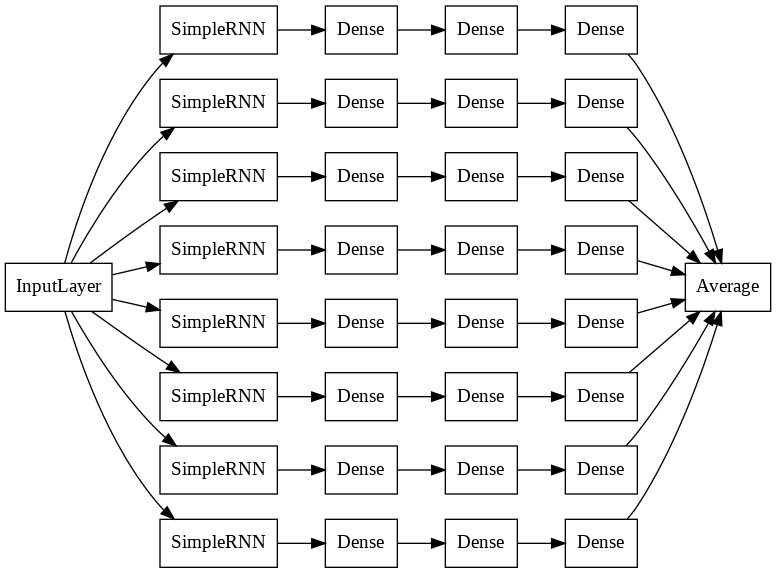

In [31]:
modelo_dot = tf.keras.utils.model_to_dot(
    modelo,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = False,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(modelo_dot.create_png()))

# Treinamento da Rede

In [32]:
def reseta_todas_camadas_treinaveis(modelo):
    for camada in modelo.layers:
        camada.trainable = True

def altera_camadas_treinaveis(modelo, k):
    for camada in modelo.layers:
        if camada.name[-len(f'_{str(k)}'):] == f'_{str(k)}':
            camada.trainable = True
        else:
            camada.trainable = False

In [33]:
def plot_curva_vies_variancia(curvas_vies_variancia, lista_loss_ref, curvas_vies_variancia_media, figsize = [6, 4]):
    paleta_cores = sns.color_palette("colorblind")
    with sns.axes_style("whitegrid"):
        for j in range(0, len(curvas_vies_variancia)):
            print(f'Conjunto {str(j)}:')
            fig, ax = plt.subplots(1, 1, figsize = figsize)
            epocas = np.arange(1, len(curvas_vies_variancia[j][0]) + 1)
            loss_train = 1 - curvas_vies_variancia[j][0]/lista_loss_ref[j][0]
            loss_val = 1 - curvas_vies_variancia[j][1]/lista_loss_ref[j][1]
            ax.plot(epocas, loss_train, color = paleta_cores[0], label = 'Treino')
            ax.plot(epocas, loss_val, color = paleta_cores[1], label = 'Validacao')
            ax.set_xlabel('Época')
            ax.set_ylabel('Loss Norm.')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()
        print('-----')
        print('Curva Média:')
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        epocas = np.arange(1, len(curvas_vies_variancia_media[0]) + 1)
        loss_train = curvas_vies_variancia_media[0]
        loss_val = curvas_vies_variancia_media[1]
        ax.plot(epocas, loss_train, color = paleta_cores[0], label = 'Treino')
        ax.plot(epocas, loss_val, color = paleta_cores[1], label = 'Validacao')
        ax.set_xlabel('Época')
        ax.set_ylabel('Loss Norm.')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
func_loss = tf.keras.losses.CategoricalCrossentropy()
modelo.compile(loss = func_loss, optimizer = opt)

In [35]:
n_loops = 10
epocas_por_loop = 2
n_batchs = 32

reseta_todas_camadas_treinaveis(modelo)
modelo.set_weights(pesos_iniciais)

callback = tf.keras.callbacks.ModelCheckpoint(
                                              'pesos_callback.h5', #hdf5
                                              monitor = 'val_loss',
                                              verbose = False,
                                              save_best_only = True,
                                              save_weights_only = True,
                                              mode = 'min',
                                              save_freq = 'epoch',
                                              )

curvas_vies_variancia = [[[], []] for v in lista_mask_trainval]
curvas_vies_variancia_media = [[], []]
lista_loss_ref = []

for i in range(0, n_loops):
    for j in range(0, len(lista_mask_trainval)):
        tupla = lista_mask_trainval[j]
        x_train = np.stack(df_p.loc[tupla[0], 'x'])
        x_val = np.stack(df_p.loc[tupla[1], 'x'])
        y_train = np.stack(df_p.loc[tupla[0], 'y'])
        y_val = np.stack(df_p.loc[tupla[1], 'y'])

        if(i == 0):
            lista_loss_ref.append((func_loss(y_train, np.tile(medias_y.values, (y_train.shape[0], 1))).numpy(), 
                                   func_loss(y_val, np.tile(medias_y.values, (y_val.shape[0], 1))).numpy()))

        altera_camadas_treinaveis(modelo, j)

        H = modelo.fit(x_train, y_train,
                            validation_data = (x_val, y_val),
                            epochs = epocas_por_loop,
                            batch_size = math.ceil(np.sum(tupla[0])/n_batchs), 
                            callbacks = callback,
                            verbose = False)
    
        reseta_todas_camadas_treinaveis(modelo)

        argmin = np.argmin(H.history['val_loss'])
        curvas_vies_variancia[j][0].extend(H.history['loss'][:argmin+1])
        curvas_vies_variancia[j][1].extend(H.history['val_loss'][:argmin+1])
        modelo.load_weights('pesos_callback.h5')

        del x_train, x_val
        del y_train, y_val
        gc.collect()

        clear_output(wait = True)
        print(f'-Loop {str(i)}')
        if(i > 0):
            loss_train_acum = 0
            loss_val_acum = 0
            for k in range(0, len(lista_mask_trainval)):
                loss_norm_train = 1 - curvas_vies_variancia[k][0][-1]/lista_loss_ref[k][0]
                loss_norm_val = 1 - curvas_vies_variancia[k][1][-1]/lista_loss_ref[k][1]
                loss_train_acum = loss_train_acum + loss_norm_train
                loss_val_acum = loss_val_acum + loss_norm_val

                loss_norm_train = round(loss_norm_train, 3)
                loss_norm_val = round(loss_norm_val, 3)
                if(k == j):
                    print(f'Conjunto {str(k)}: {str(loss_norm_train)} / {str(loss_norm_val)} <-')
                else:
                    print(f'Conjunto {str(k)}: {str(loss_norm_train)} / {str(loss_norm_val)}')
            
            loss_train_acum = loss_train_acum/len(lista_mask_trainval)
            loss_val_acum = loss_val_acum/len(lista_mask_trainval)
            curvas_vies_variancia_media[0].append(loss_train_acum)
            curvas_vies_variancia_media[1].append(loss_val_acum)

            loss_train_acum = round(loss_train_acum, 3)
            loss_val_acum = round(loss_val_acum, 3)
            print('-----')
            print(f'Média: {str(loss_train_acum)} / {str(loss_val_acum)}')
        else:
            loss_norm_train = round(1 - curvas_vies_variancia[j][0][-1]/lista_loss_ref[j][0], 3)
            loss_norm_val = round(1 - curvas_vies_variancia[j][1][-1]/lista_loss_ref[j][1], 3)
            print(f'Conjunto {str(j)}: {str(loss_norm_train)} / {str(loss_norm_val)}')

-Loop 8
Conjunto 0: 0.506 / 0.89
Conjunto 1: 0.425 / 0.459
Conjunto 2: 0.513 / 0.564
Conjunto 3: 0.489 / 0.141
Conjunto 4: 0.496 / 0.602
Conjunto 5: 0.524 / 0.518 <-
Conjunto 6: 0.543 / 0.617
Conjunto 7: 0.527 / 0.268
-----
Média: 0.503 / 0.507


KeyboardInterrupt: ignored

In [ ]:
plot_curva_vies_variancia(curvas_vies_variancia, lista_loss_ref, curvas_vies_variancia_media, figsize = [6, 2])

# Avaliação

In [ ]:
def calcula_loss_norm(func_loss, autoencoder, X, medias, desvios):
    X_norm = norm(X, medias, desvios)
    loss_ref = func_loss(X_norm, np.zeros(shape = X.shape)).numpy()
    pred = autoencoder.predict(X_norm)
    loss = func_loss(X_norm, pred).numpy()
    return 1 - loss/loss_ref

In [ ]:
dict_loss_norm = {
          'Treino': calcula_loss_norm(func_loss, autoencoder, df.loc[mask_treino, features].values, medias, desvios),
          'Teste': calcula_loss_norm(func_loss, autoencoder, df.loc[mask_teste, features].values, medias, desvios)
          }

In [ ]:
display(pd.DataFrame(pd.Series(dict_loss_norm)))

,0
Treino,0.198937
Teste,0.195826


In [ ]:
def plot_loss_norm_temporal(df_loss_norm_tempo, corta_tempo, figsize = [6, 4]):
    paleta_cores = sns.color_palette("colorblind")
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        i = 0
        for conjunto in ['Treino', 'Teste']:
            df_aux = df_loss_norm_tempo.loc[df_loss_norm_tempo.index.get_level_values(0) == conjunto, :]
            tempo_disc = df_aux.index.get_level_values(1)
            map_tempo = dict(zip(np.arange(corta_tempo.strings_intervalos_discretizacao().size), corta_tempo.strings_intervalos_discretizacao()))
            tempo = [map_tempo[v] for v in tempo_disc]
            loss_norm = df_aux['Loss_Norm']
            ax.plot(tempo, loss_norm, 'o-', color = paleta_cores[i], label = conjunto)
            i = i + 1
        ax.set_xlabel('Tempo')
        ax.set_ylabel('Loss Norm.')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_ylim([0, 1])
        plt.xticks(rotation = 90)
        plt.show()

In [ ]:
df_aval = df.loc[:, features].copy()
corta_tempo = trf.CortaIntervalosQuasiUniforme(df[coluna_temporal].values, num_div = 50)
df_aval['Tempo_Disc'] = corta_tempo.aplica_discretizacao(df[coluna_temporal].values)
df_aval['Conjunto'] = np.nan
df_aval.loc[mask_treino, 'Conjunto'] = 'Treino'
df_aval.loc[mask_teste, 'Conjunto'] = 'Teste'
df_loss_norm_tempo = pd.DataFrame(df_aval.groupby(['Conjunto', 'Tempo_Disc']).apply(lambda x: calcula_loss_norm(func_loss, autoencoder, x.loc[:, features].values, medias, desvios)), columns = ['Loss_Norm'])

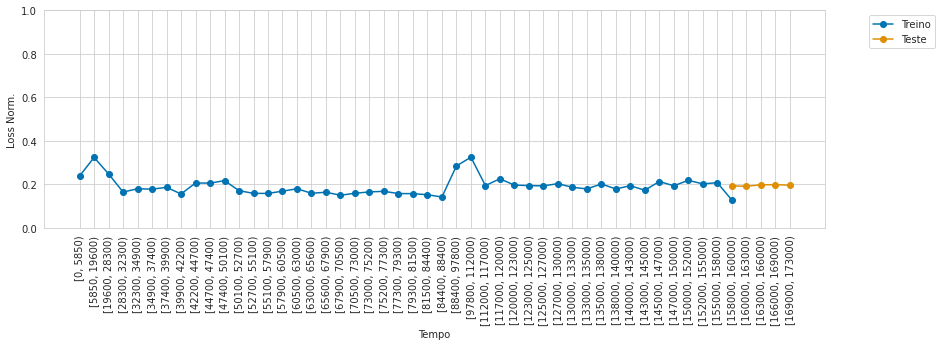

In [ ]:
plot_loss_norm_temporal(df_loss_norm_tempo, corta_tempo, figsize = [14, 4])